### 초기 경로 설정 (클래스 이용을 위함)

In [9]:
%cd /project/segmentation/smcho1201/segmentation_project

/project/segmentation/smcho1201/segmentation_project


In [10]:
# files and system
import os
import sys
import time
import random

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import glob
from IPython.display import clear_output
# working with images
import cv2
import imageio
import scipy.ndimage
# import skimage.transform

import torchvision.transforms as transforms

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F


import torchsummary
from tqdm import notebook

sys.path.insert(0, '..')

# losses
from utils.metrics import iou_pytorch_eval, IoULoss, IoUBCELoss, DiceBCELoss , dice_pytorch_eval
from utils.metrics import iou_pytorch_test, dice_pytorch_test, precision_pytorch_test, recall_pytorch_test, fbeta_pytorch_test, accuracy_pytorch_test

# dataset
from utils.dataset import myDataSet

## 랜덤성을 배제한 환경 고정

In [11]:
random_seed= 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.backends.cudnn.deterministic = True

In [12]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # select device for training, i.e. gpu or cpu
print(DEVICE)

cuda:0


# 1. Image augentation
> 실험할 때는 아예 augmentation도 고정시켜서 저장한 이미지를 사용해야 함.

In [13]:
_size = 224, 224
resize = transforms.Resize(_size, interpolation=0)

# set your transforms 
train_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                           transforms.RandomRotation(180),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(_size, padding = 10), # needed after rotation (with original size)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(_size, interpolation=0),
                       ])

# 2. 데이터셋 클래스 생성
> 해당 클래스는 이용하려는 이미지와 라벨의 모든 경로(/data/segmentation/...)의 리스트를 인자로 받는다.   

In [14]:
train_images = glob.glob('/data/segmentation/breast-cancer/trainset_malignant/images/*')
train_labels = glob.glob('/data/segmentation/breast-cancer/trainset_malignant/labels/*')
train_images = [img for img in train_images if img.find('jpg')!= -1] # super pixels 이미지 제외

valid_images = glob.glob('/data/segmentation/breast-cancer/validationset_malignant/images/*')
valid_labels = glob.glob('/data/segmentation/breast-cancer/validationset_malignant/labels/*')
valid_images = [img for img in valid_images if img.find('jpg')!= -1] # super pixels 이미지 제외

train_images = sorted(train_images)
train_labels = sorted(train_labels)

valid_images = sorted(valid_images)
valid_labels = sorted(valid_labels)

# 데이터셋 클래스 적용
custom_dataset_train = myDataSet(train_images, train_labels, transforms=test_transforms)
print("My custom training-dataset has {} elements".format(len(custom_dataset_train)))

custom_dataset_val = myDataSet(valid_images, valid_labels, transforms=test_transforms)
print("My custom valing-dataset has {} elements".format(len(custom_dataset_val)))

My custom training-dataset has 126 elements
My custom valing-dataset has 42 elements


### dataset class check
> RGB 채널 평균 값이라 색 바뀜

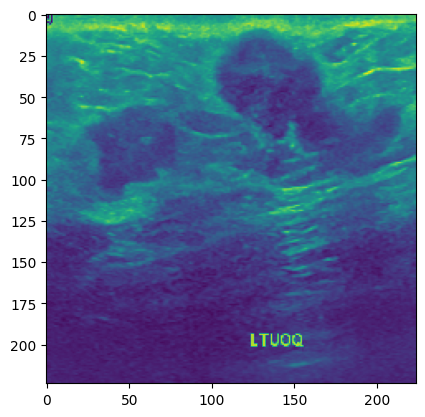

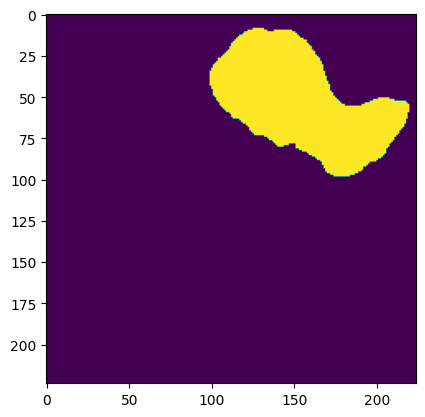

3픽셀의 평균값이라 색깔이 변경됨.


In [15]:
# Show example images.
image_number = 23
img, mask = custom_dataset_train.__getitem__(image_number)

# image
plt.figure()
plt.imshow(img.mean(0)) # 3 channels, take mean

# mask
plt.figure()
plt.imshow(mask[0, :, :]) # 1 channel, take it

plt.show()
print('3픽셀의 평균값이라 색깔이 변경됨.')

# 3. 모델 클래스 생성

In [16]:
# Begin training
from models.FCN.vision.vision.torchvision.models.segmentation.fcn import fcn_resnet101
model = fcn_resnet101(num_classes = 1)
model = model.to(DEVICE) # load model to DEVICE

# 4. 하이퍼 파라미터 세팅 & 데이터 로더 생성

In [17]:
# Define variables for the training
epochs = 100
patience = 20
BATCH_SIZE = 8

dataloader_train = torch.utils.data.DataLoader(custom_dataset_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
dataloader_val = torch.utils.data.DataLoader(custom_dataset_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [18]:
# Define optimiser and criterion for the training. You can try different ones to see which works best for your data and task
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-4, weight_decay = 1e-8)

criterion = DiceBCELoss()
model_name = 'FCN'
data_name = 'malignant'

# 5. Training

/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:749: UserWarning: Note that order of the arguments: ceil_mode and return_indices will changeto match the args list in nn.MaxPool2d in a future release.
  warnings.warn("Note that order of the arguments: ceil_mode and return_indices will change"
/home/smcho1201/.conda/envs/pytorch/lib/python3.9/site-packages/torch/nn/functional.py:1944: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


 Epoch: 1 of 100, Iter.: 16 of 16, Train Loss: 1.451807, IoU: 0.124982, Dice: 0.215545
 Epoch: 1 of 100, Iter.: 16 of 16, Valid Loss: 1.454449, IoU: 0.036876, Dice: 0.070882

시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.


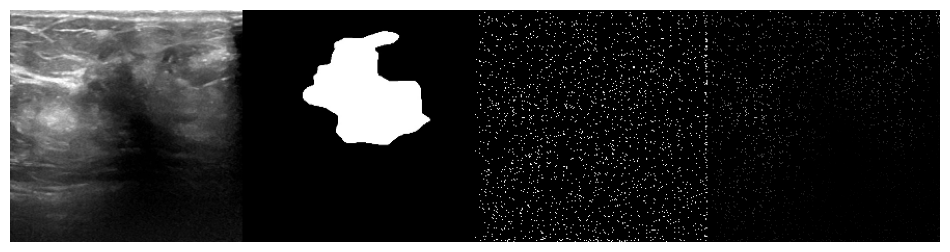

 Epoch: 2 of 100, Iter.: 16 of 16, Train Loss: 1.401119, IoU: 0.232650, Dice: 0.359553
 Epoch: 2 of 100, Iter.: 16 of 16, Valid Loss: 1.395328, IoU: 0.252971, Dice: 0.386866


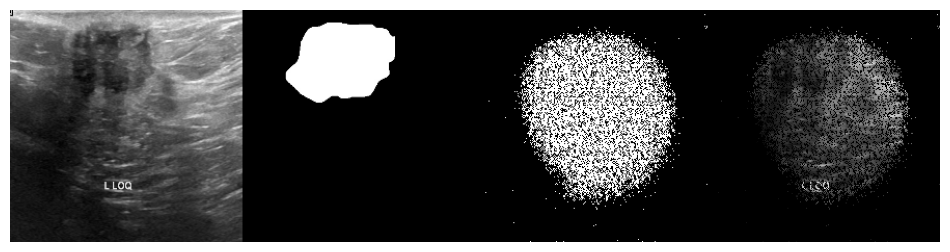

 Epoch: 3 of 100, Iter.: 16 of 16, Train Loss: 1.320176, IoU: 0.361005, Dice: 0.502627
 Epoch: 3 of 100, Iter.: 16 of 16, Valid Loss: 1.354147, IoU: 0.284525, Dice: 0.420079


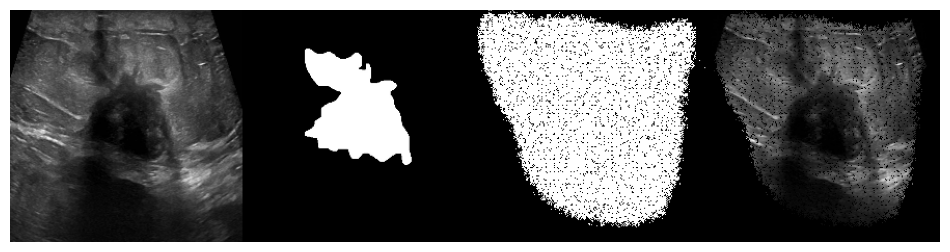

 Epoch: 4 of 100, Iter.: 16 of 16, Train Loss: 1.214523, IoU: 0.464301, Dice: 0.603186
 Epoch: 4 of 100, Iter.: 16 of 16, Valid Loss: 1.277580, IoU: 0.292140, Dice: 0.428457


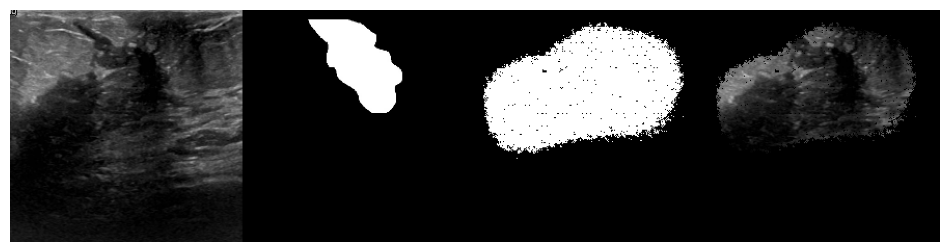

 Epoch: 5 of 100, Iter.: 16 of 16, Train Loss: 1.078587, IoU: 0.521382, Dice: 0.652123
 Epoch: 5 of 100, Iter.: 16 of 16, Valid Loss: 1.144762, IoU: 0.355432, Dice: 0.497272


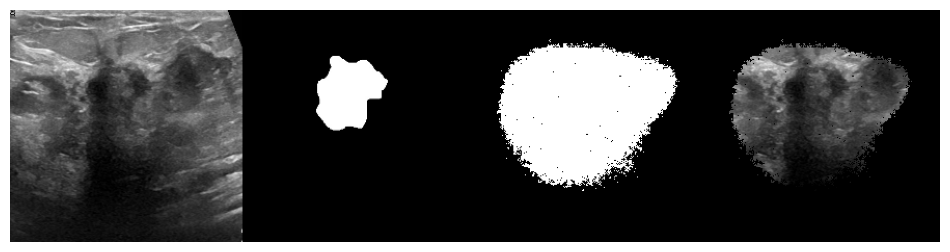

 Epoch: 6 of 100, Iter.: 16 of 16, Train Loss: 0.941114, IoU: 0.558160, Dice: 0.691938
 Epoch: 6 of 100, Iter.: 16 of 16, Valid Loss: 0.985519, IoU: 0.423520, Dice: 0.563588


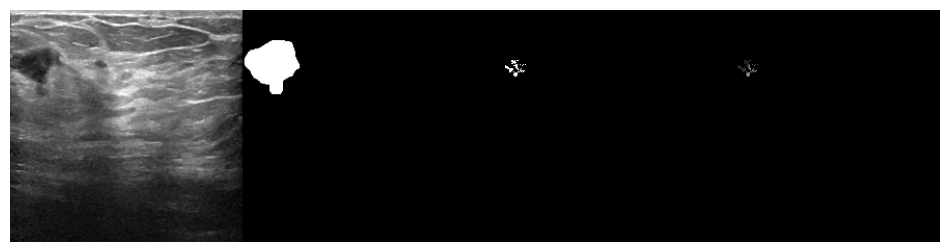

 Epoch: 7 of 100, Iter.: 16 of 16, Train Loss: 0.801525, IoU: 0.617511, Dice: 0.749862
 Epoch: 7 of 100, Iter.: 16 of 16, Valid Loss: 0.912459, IoU: 0.430302, Dice: 0.566426


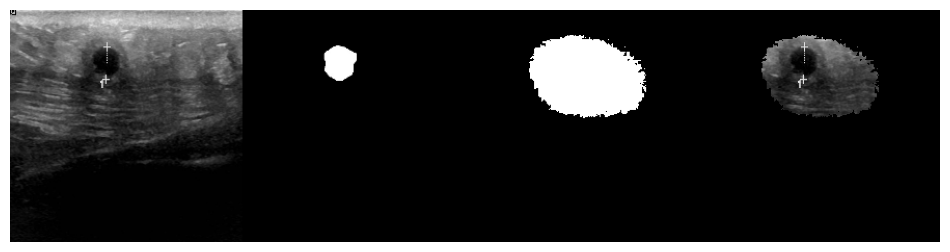

 Epoch: 8 of 100, Iter.: 16 of 16, Train Loss: 0.686990, IoU: 0.622781, Dice: 0.746329
 Epoch: 8 of 100, Iter.: 16 of 16, Valid Loss: 0.766507, IoU: 0.492405, Dice: 0.635893


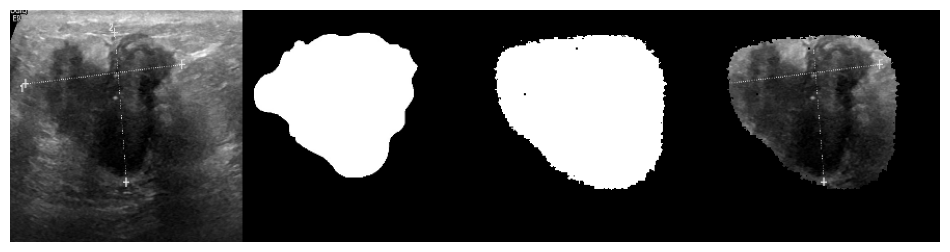

 Epoch: 9 of 100, Iter.: 16 of 16, Train Loss: 0.624211, IoU: 0.626750, Dice: 0.756494
 Epoch: 9 of 100, Iter.: 16 of 16, Valid Loss: 0.807444, IoU: 0.449631, Dice: 0.592416


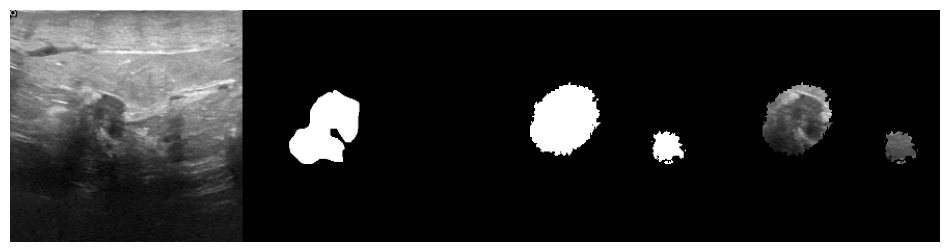

 Epoch: 10 of 100, Iter.: 16 of 16, Train Loss: 0.509167, IoU: 0.676484, Dice: 0.792804
 Epoch: 10 of 100, Iter.: 16 of 16, Valid Loss: 0.785520, IoU: 0.449931, Dice: 0.593054


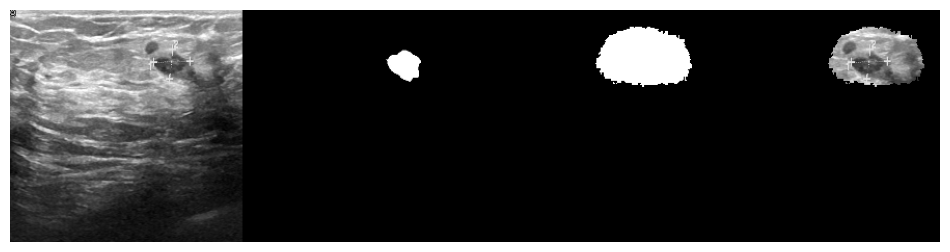

 Epoch: 11 of 100, Iter.: 16 of 16, Train Loss: 0.455936, IoU: 0.682632, Dice: 0.798775
 Epoch: 11 of 100, Iter.: 16 of 16, Valid Loss: 0.641150, IoU: 0.515126, Dice: 0.640163


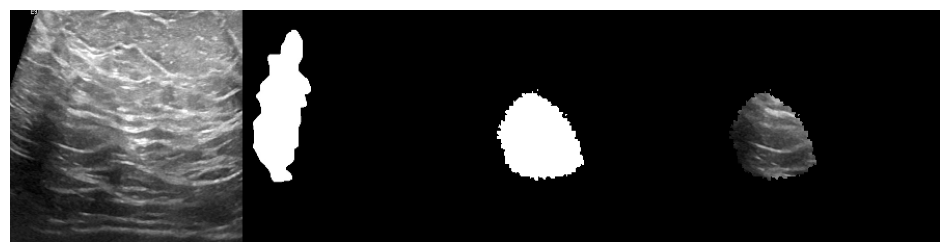

 Epoch: 12 of 100, Iter.: 16 of 16, Train Loss: 0.381264, IoU: 0.718744, Dice: 0.821795
 Epoch: 12 of 100, Iter.: 16 of 16, Valid Loss: 0.630109, IoU: 0.533275, Dice: 0.662065


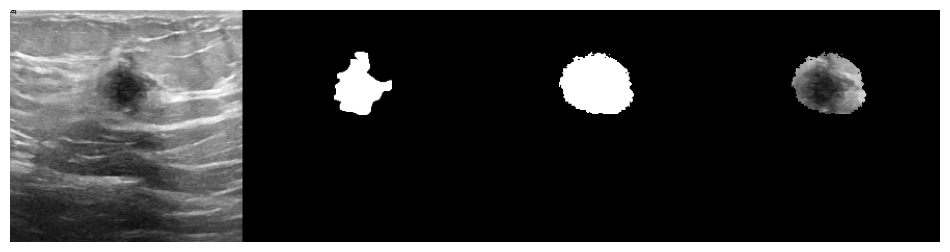

 Epoch: 13 of 100, Iter.: 16 of 16, Train Loss: 0.344387, IoU: 0.730319, Dice: 0.833874
 Epoch: 13 of 100, Iter.: 16 of 16, Valid Loss: 0.609065, IoU: 0.539780, Dice: 0.669788


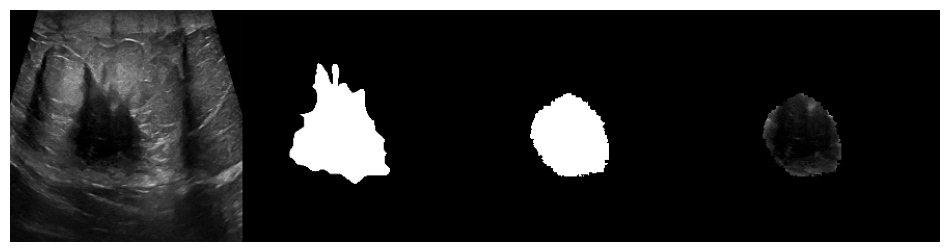

 Epoch: 14 of 100, Iter.: 16 of 16, Train Loss: 0.301078, IoU: 0.764542, Dice: 0.859583
 Epoch: 14 of 100, Iter.: 16 of 16, Valid Loss: 0.600455, IoU: 0.538929, Dice: 0.670189


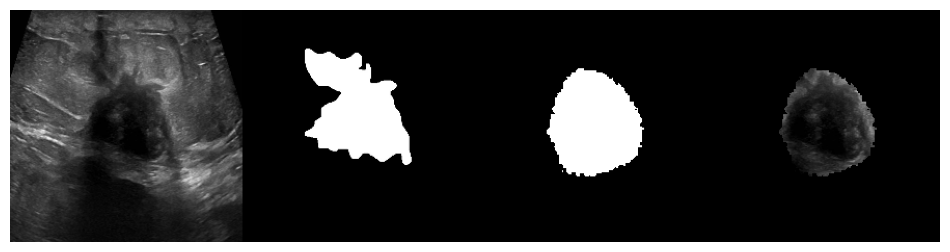

 Epoch: 15 of 100, Iter.: 16 of 16, Train Loss: 0.261918, IoU: 0.790151, Dice: 0.876161
 Epoch: 15 of 100, Iter.: 16 of 16, Valid Loss: 0.621572, IoU: 0.527268, Dice: 0.659138


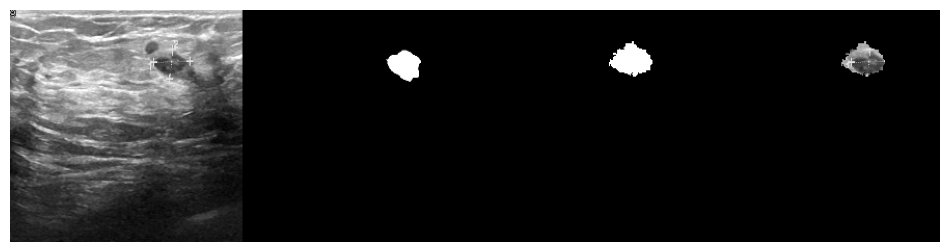

 Epoch: 16 of 100, Iter.: 16 of 16, Train Loss: 0.246751, IoU: 0.799527, Dice: 0.882757
 Epoch: 16 of 100, Iter.: 16 of 16, Valid Loss: 0.695712, IoU: 0.476380, Dice: 0.595971


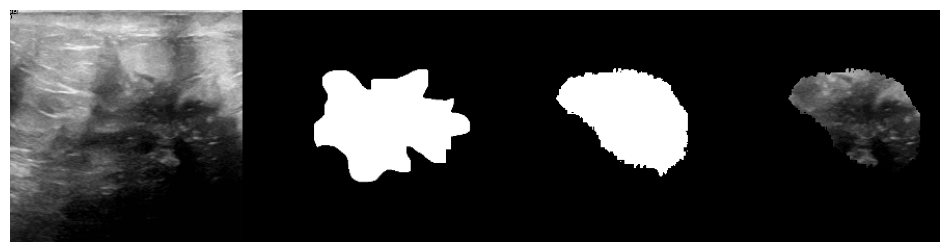

 Epoch: 17 of 100, Iter.: 16 of 16, Train Loss: 0.243654, IoU: 0.800047, Dice: 0.883833
 Epoch: 17 of 100, Iter.: 16 of 16, Valid Loss: 0.579001, IoU: 0.525650, Dice: 0.648415


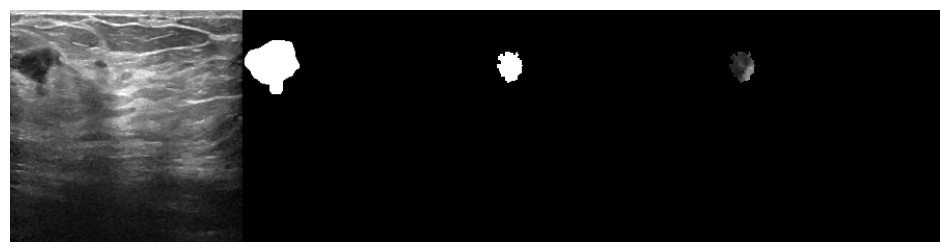

 Epoch: 18 of 100, Iter.: 16 of 16, Train Loss: 0.242993, IoU: 0.794638, Dice: 0.876856
 Epoch: 18 of 100, Iter.: 16 of 16, Valid Loss: 0.862440, IoU: 0.378809, Dice: 0.504327


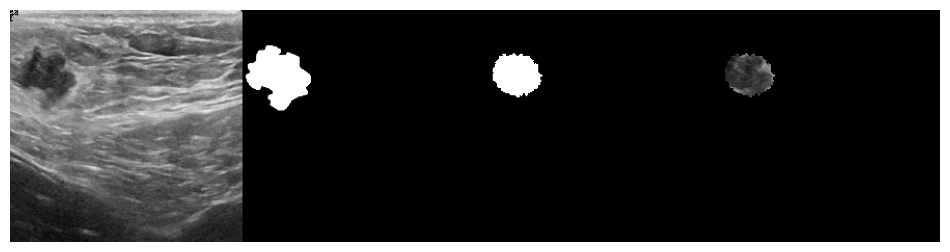

 Epoch: 19 of 100, Iter.: 16 of 16, Train Loss: 0.240147, IoU: 0.787494, Dice: 0.874968
 Epoch: 19 of 100, Iter.: 16 of 16, Valid Loss: 0.680714, IoU: 0.481236, Dice: 0.607687


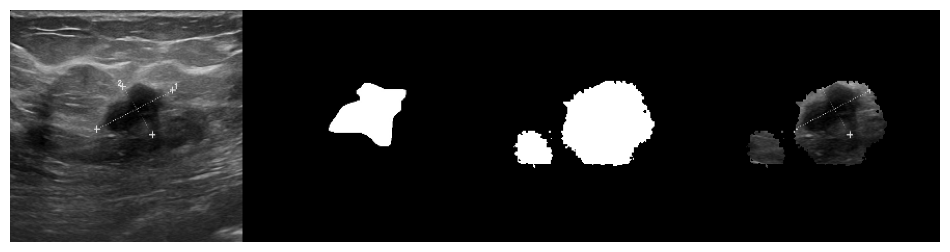

 Epoch: 20 of 100, Iter.: 16 of 16, Train Loss: 0.237654, IoU: 0.778073, Dice: 0.865818
 Epoch: 20 of 100, Iter.: 16 of 16, Valid Loss: 0.596473, IoU: 0.538079, Dice: 0.667431


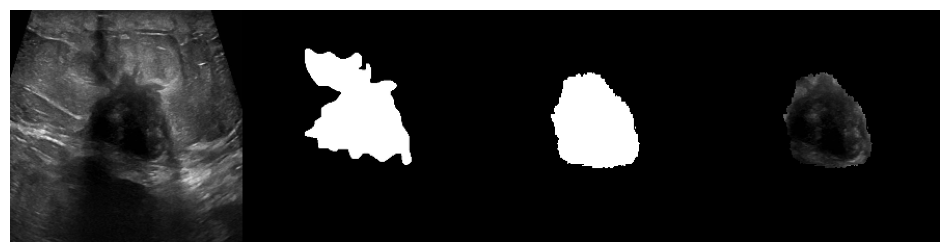

 Epoch: 21 of 100, Iter.: 16 of 16, Train Loss: 0.216842, IoU: 0.793248, Dice: 0.878883
 Epoch: 21 of 100, Iter.: 16 of 16, Valid Loss: 0.760194, IoU: 0.474596, Dice: 0.589087


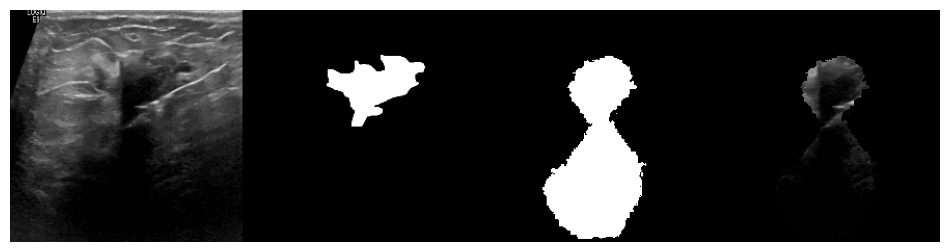

 Epoch: 22 of 100, Iter.: 16 of 16, Train Loss: 0.204724, IoU: 0.817494, Dice: 0.893852
 Epoch: 22 of 100, Iter.: 16 of 16, Valid Loss: 0.787368, IoU: 0.414231, Dice: 0.524386


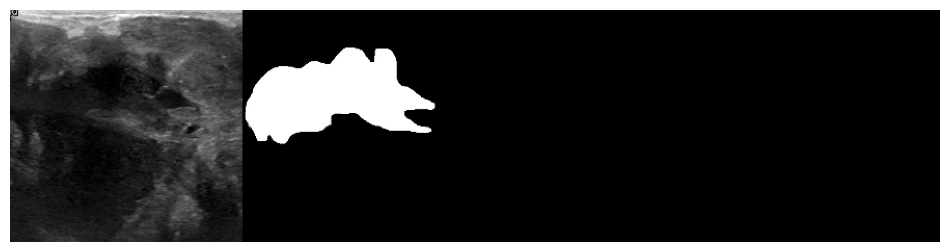

 Epoch: 23 of 100, Iter.: 16 of 16, Train Loss: 0.194157, IoU: 0.810301, Dice: 0.887876
 Epoch: 23 of 100, Iter.: 16 of 16, Valid Loss: 0.661298, IoU: 0.493514, Dice: 0.613259


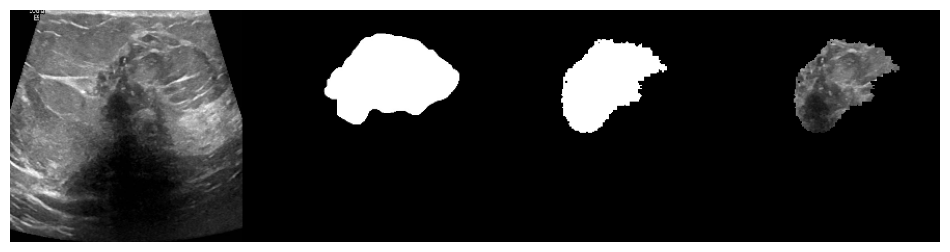

 Epoch: 24 of 100, Iter.: 16 of 16, Train Loss: 0.164268, IoU: 0.838876, Dice: 0.907566
 Epoch: 24 of 100, Iter.: 16 of 16, Valid Loss: 0.711836, IoU: 0.494606, Dice: 0.614776


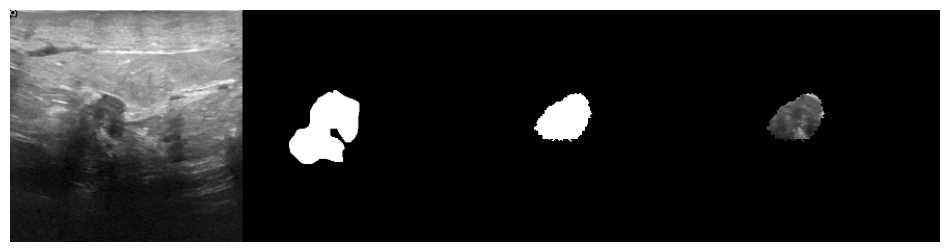

 Epoch: 25 of 100, Iter.: 16 of 16, Train Loss: 0.149600, IoU: 0.851754, Dice: 0.914017
 Epoch: 25 of 100, Iter.: 16 of 16, Valid Loss: 0.774427, IoU: 0.477146, Dice: 0.596505


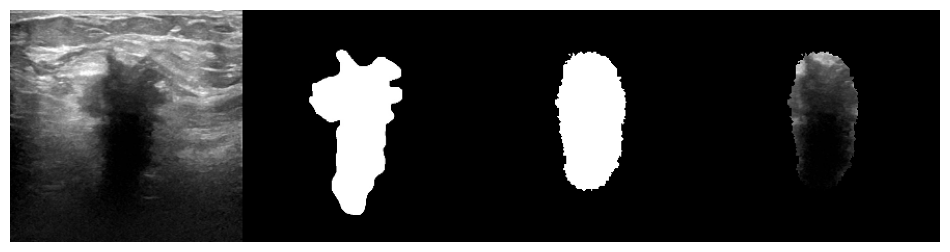

 Epoch: 26 of 100, Iter.: 16 of 16, Train Loss: 0.149159, IoU: 0.855016, Dice: 0.917212
 Epoch: 26 of 100, Iter.: 16 of 16, Valid Loss: 0.784528, IoU: 0.429430, Dice: 0.534523


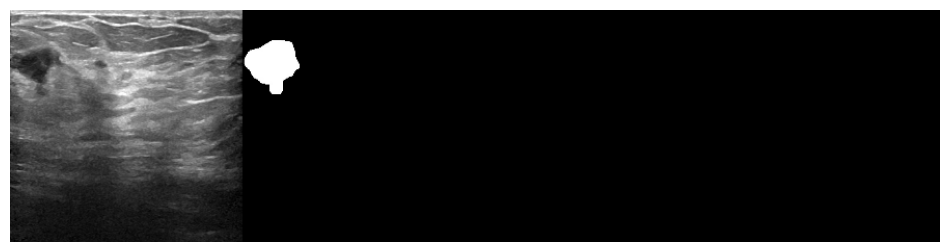

 Epoch: 27 of 100, Iter.: 16 of 16, Train Loss: 0.132067, IoU: 0.864546, Dice: 0.922693
 Epoch: 27 of 100, Iter.: 16 of 16, Valid Loss: 0.687322, IoU: 0.519851, Dice: 0.641146


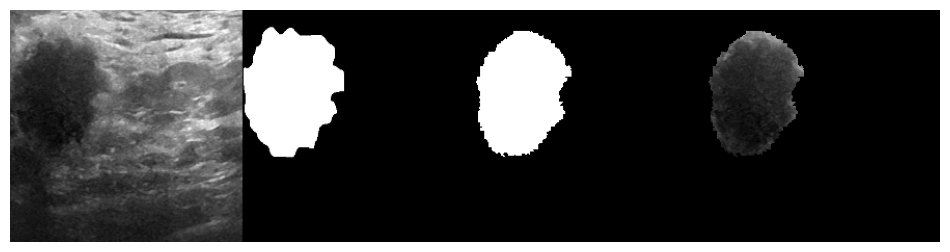

 Epoch: 28 of 100, Iter.: 16 of 16, Train Loss: 0.134683, IoU: 0.864198, Dice: 0.920965
 Epoch: 28 of 100, Iter.: 16 of 16, Valid Loss: 0.750408, IoU: 0.550503, Dice: 0.675658


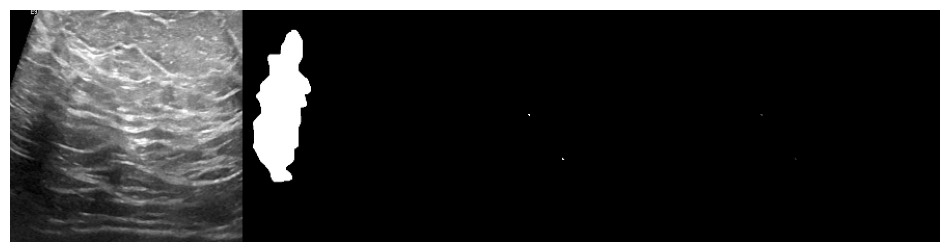

 Epoch: 29 of 100, Iter.: 16 of 16, Train Loss: 0.167351, IoU: 0.843299, Dice: 0.909342
 Epoch: 29 of 100, Iter.: 16 of 16, Valid Loss: 0.814064, IoU: 0.484455, Dice: 0.604540


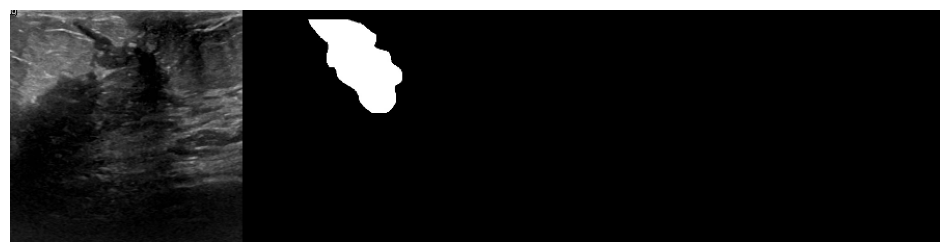

 Epoch: 30 of 100, Iter.: 16 of 16, Train Loss: 0.198378, IoU: 0.807780, Dice: 0.882450
 Epoch: 30 of 100, Iter.: 16 of 16, Valid Loss: 0.708562, IoU: 0.485581, Dice: 0.618932


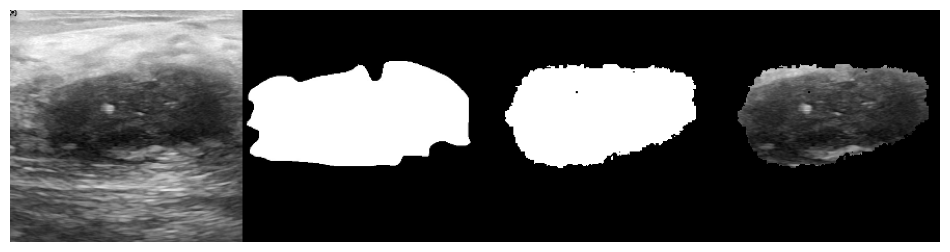

 Epoch: 31 of 100, Iter.: 16 of 16, Train Loss: 0.184926, IoU: 0.816609, Dice: 0.892523
 Epoch: 31 of 100, Iter.: 16 of 16, Valid Loss: 0.763860, IoU: 0.474288, Dice: 0.601415


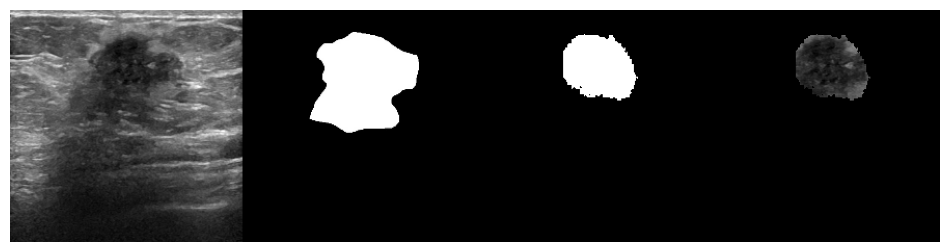

 Epoch: 32 of 100, Iter.: 16 of 16, Train Loss: 0.179335, IoU: 0.821753, Dice: 0.893412
 Epoch: 32 of 100, Iter.: 16 of 16, Valid Loss: 0.791079, IoU: 0.416187, Dice: 0.533962


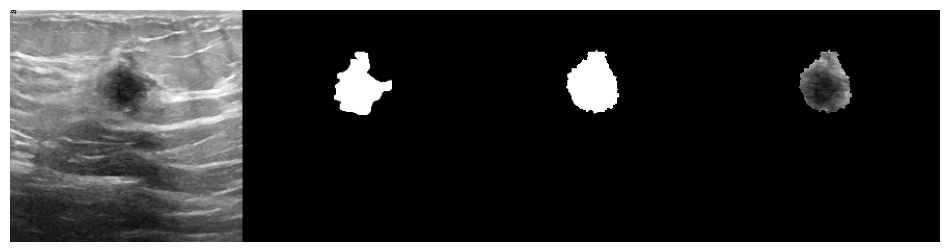

 Epoch: 33 of 100, Iter.: 16 of 16, Train Loss: 0.148857, IoU: 0.843659, Dice: 0.912032
 Epoch: 33 of 100, Iter.: 16 of 16, Valid Loss: 0.639072, IoU: 0.507001, Dice: 0.624780


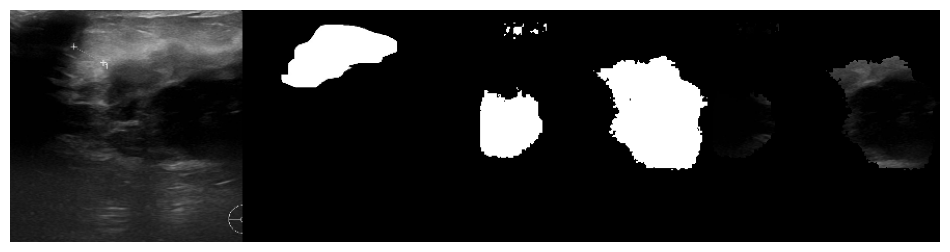

 Epoch: 34 of 100, Iter.: 16 of 16, Train Loss: 0.130892, IoU: 0.859149, Dice: 0.919571
 Epoch: 34 of 100, Iter.: 16 of 16, Valid Loss: 0.668321, IoU: 0.510249, Dice: 0.630038


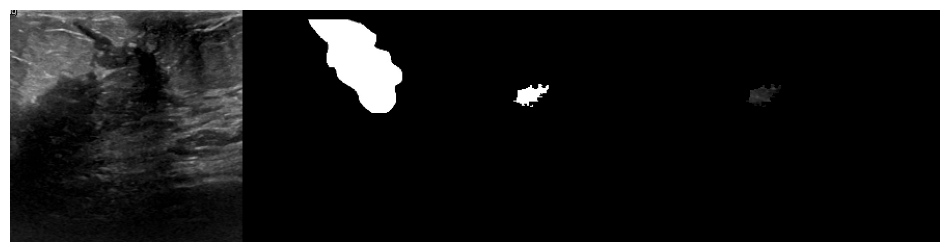

 Epoch: 35 of 100, Iter.: 16 of 16, Train Loss: 0.115702, IoU: 0.878956, Dice: 0.934649
 Epoch: 35 of 100, Iter.: 16 of 16, Valid Loss: 0.610019, IoU: 0.556004, Dice: 0.679558


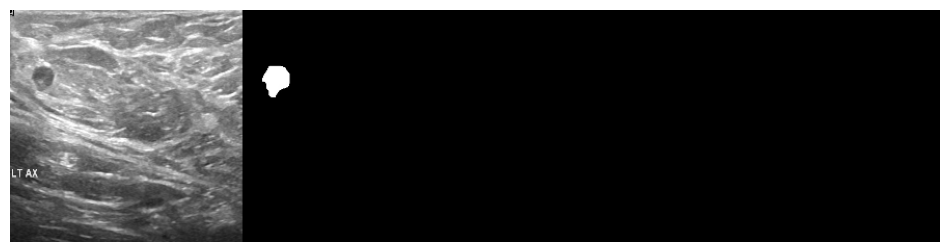

 Epoch: 36 of 100, Iter.: 16 of 16, Train Loss: 0.113436, IoU: 0.884276, Dice: 0.937109
 Epoch: 36 of 100, Iter.: 16 of 16, Valid Loss: 0.639157, IoU: 0.543103, Dice: 0.666006


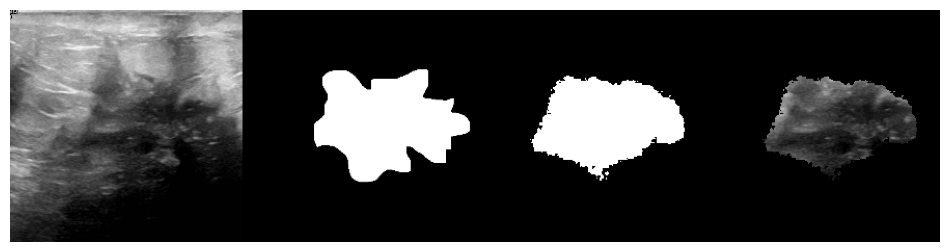

 Epoch: 37 of 100, Iter.: 16 of 16, Train Loss: 0.093629, IoU: 0.900127, Dice: 0.946612
 Epoch: 37 of 100, Iter.: 16 of 16, Valid Loss: 0.644290, IoU: 0.542358, Dice: 0.662717


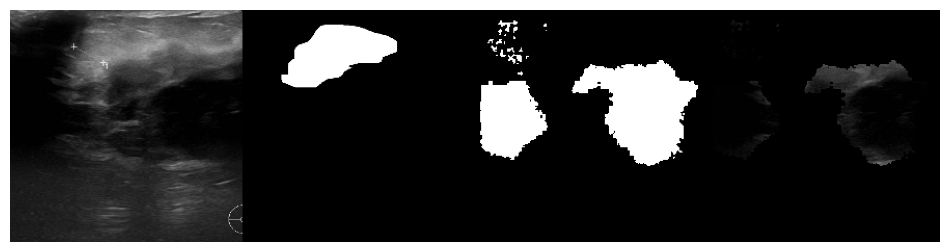

 Epoch: 38 of 100, Iter.: 16 of 16, Train Loss: 0.092161, IoU: 0.901923, Dice: 0.947700
 Epoch: 38 of 100, Iter.: 16 of 16, Valid Loss: 0.655961, IoU: 0.548221, Dice: 0.667969


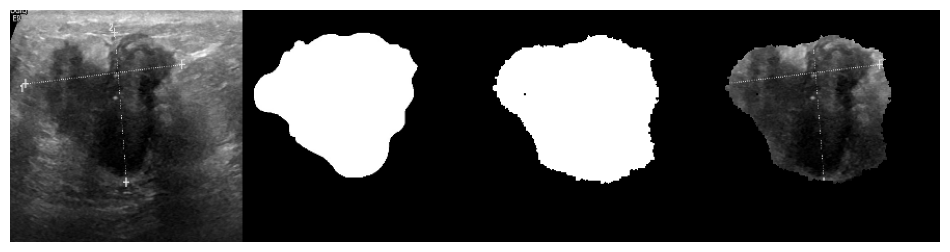

 Epoch: 39 of 100, Iter.: 16 of 16, Train Loss: 0.086399, IoU: 0.907418, Dice: 0.950738
 Epoch: 39 of 100, Iter.: 16 of 16, Valid Loss: 0.669686, IoU: 0.545965, Dice: 0.666163


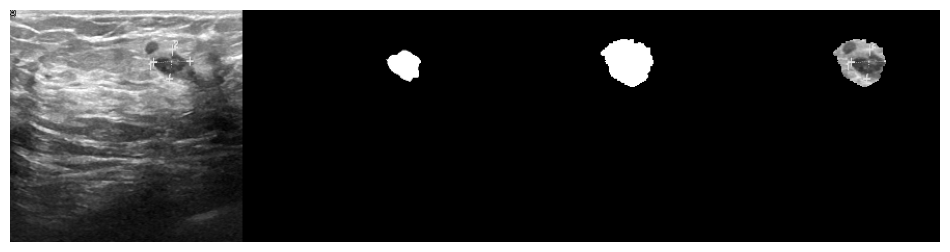

 Epoch: 40 of 100, Iter.: 16 of 16, Train Loss: 0.088514, IoU: 0.908933, Dice: 0.951657
 Epoch: 40 of 100, Iter.: 16 of 16, Valid Loss: 0.688230, IoU: 0.536335, Dice: 0.658352


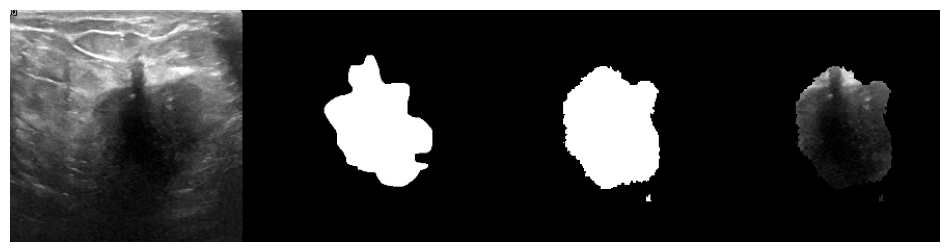

 Epoch: 41 of 100, Iter.: 16 of 16, Train Loss: 0.080948, IoU: 0.911080, Dice: 0.952818
 Epoch: 41 of 100, Iter.: 16 of 16, Valid Loss: 0.653976, IoU: 0.561298, Dice: 0.679798


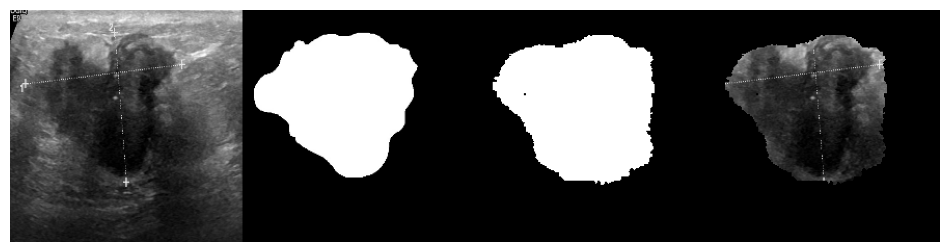

 Epoch: 42 of 100, Iter.: 16 of 16, Train Loss: 0.078490, IoU: 0.917866, Dice: 0.956727
 Epoch: 42 of 100, Iter.: 16 of 16, Valid Loss: 0.667350, IoU: 0.555642, Dice: 0.674956


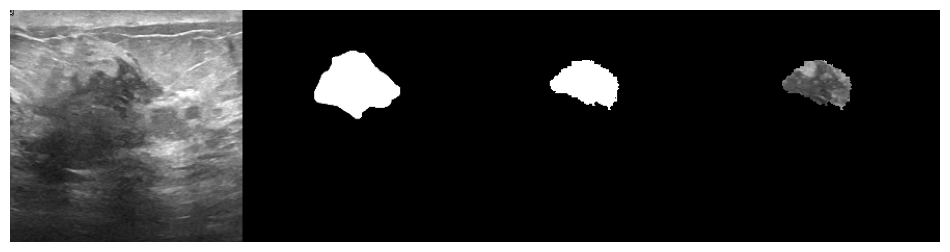

 Epoch: 43 of 100, Iter.: 16 of 16, Train Loss: 0.074632, IoU: 0.917652, Dice: 0.956268
 Epoch: 43 of 100, Iter.: 16 of 16, Valid Loss: 0.659583, IoU: 0.566682, Dice: 0.682900


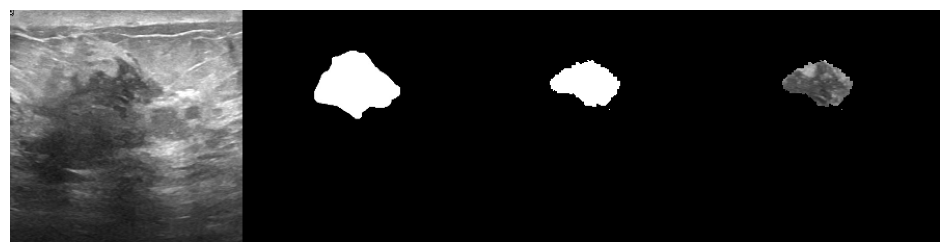

 Epoch: 44 of 100, Iter.: 16 of 16, Train Loss: 0.070871, IoU: 0.921752, Dice: 0.958805
 Epoch: 44 of 100, Iter.: 16 of 16, Valid Loss: 0.673073, IoU: 0.561575, Dice: 0.678316


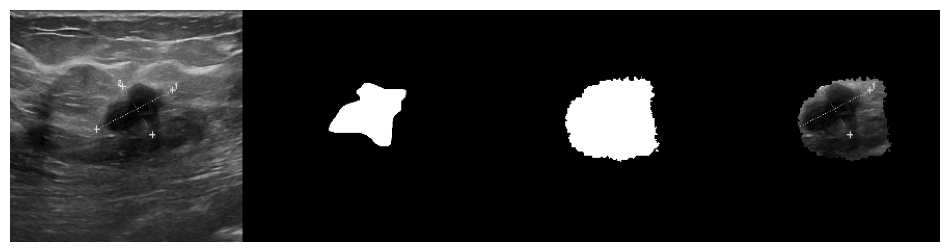

 Epoch: 45 of 100, Iter.: 16 of 16, Train Loss: 0.070873, IoU: 0.921806, Dice: 0.958782
 Epoch: 45 of 100, Iter.: 16 of 16, Valid Loss: 0.687071, IoU: 0.553198, Dice: 0.671149


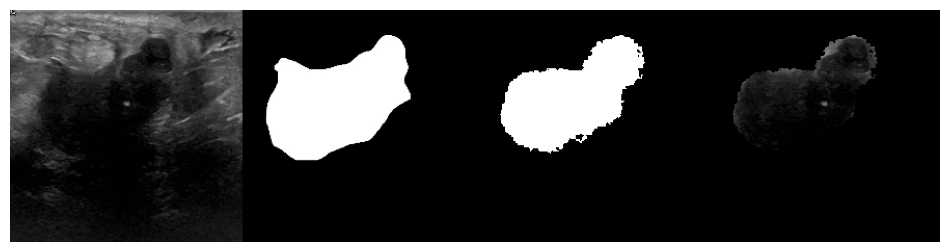

 Epoch: 46 of 100, Iter.: 16 of 16, Train Loss: 0.068094, IoU: 0.925243, Dice: 0.960792
 Epoch: 46 of 100, Iter.: 16 of 16, Valid Loss: 0.673466, IoU: 0.570210, Dice: 0.687013


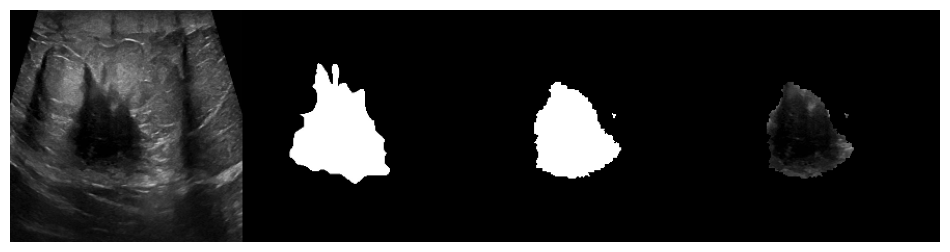

 Epoch: 47 of 100, Iter.: 16 of 16, Train Loss: 0.067062, IoU: 0.925868, Dice: 0.960977
 Epoch: 47 of 100, Iter.: 16 of 16, Valid Loss: 0.701854, IoU: 0.557014, Dice: 0.676658


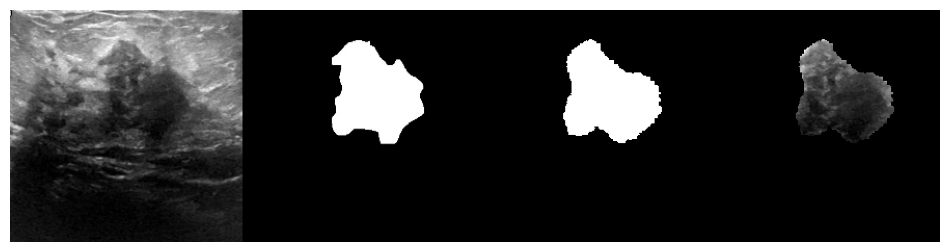

 Epoch: 48 of 100, Iter.: 16 of 16, Train Loss: 0.064365, IoU: 0.927952, Dice: 0.962308
 Epoch: 48 of 100, Iter.: 16 of 16, Valid Loss: 0.702481, IoU: 0.558979, Dice: 0.678810


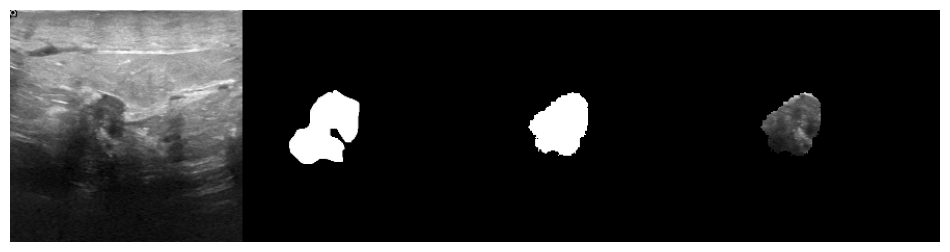

 Epoch: 49 of 100, Iter.: 16 of 16, Train Loss: 0.067723, IoU: 0.926583, Dice: 0.961531
 Epoch: 49 of 100, Iter.: 16 of 16, Valid Loss: 0.696198, IoU: 0.554109, Dice: 0.673061


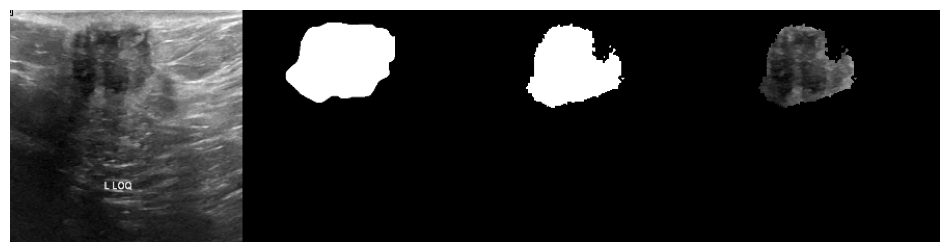

 Epoch: 50 of 100, Iter.: 16 of 16, Train Loss: 0.064801, IoU: 0.929153, Dice: 0.962950
 Epoch: 50 of 100, Iter.: 16 of 16, Valid Loss: 0.712534, IoU: 0.552904, Dice: 0.669969


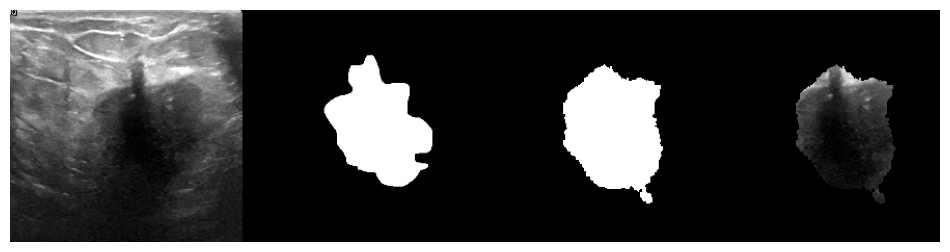

 Epoch: 51 of 100, Iter.: 16 of 16, Train Loss: 0.063283, IoU: 0.931044, Dice: 0.963971
 Epoch: 51 of 100, Iter.: 16 of 16, Valid Loss: 0.744806, IoU: 0.530721, Dice: 0.649107


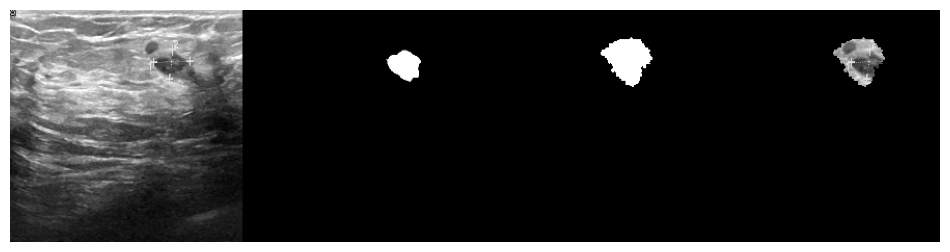

 Epoch: 52 of 100, Iter.: 16 of 16, Train Loss: 0.063061, IoU: 0.930251, Dice: 0.963518
 Epoch: 52 of 100, Iter.: 16 of 16, Valid Loss: 0.770862, IoU: 0.529050, Dice: 0.650676


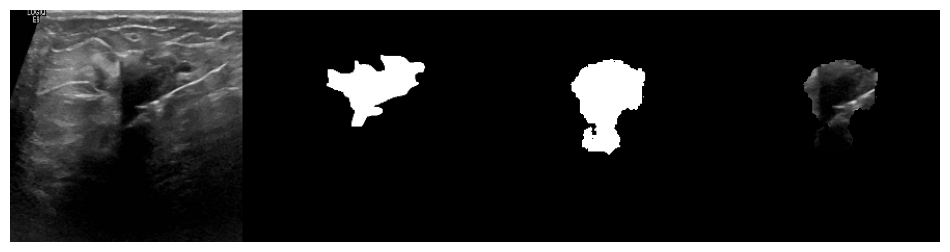

 Epoch: 53 of 100, Iter.: 16 of 16, Train Loss: 0.059433, IoU: 0.932702, Dice: 0.964841
 Epoch: 53 of 100, Iter.: 16 of 16, Valid Loss: 0.744259, IoU: 0.544106, Dice: 0.662206


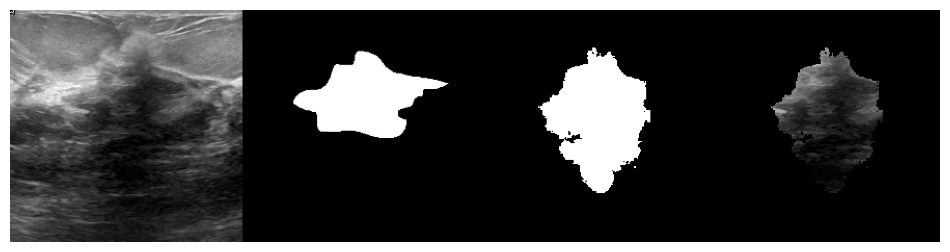

 Epoch: 54 of 100, Iter.: 16 of 16, Train Loss: 0.061405, IoU: 0.932616, Dice: 0.964865
 Epoch: 54 of 100, Iter.: 16 of 16, Valid Loss: 0.752336, IoU: 0.549856, Dice: 0.669055


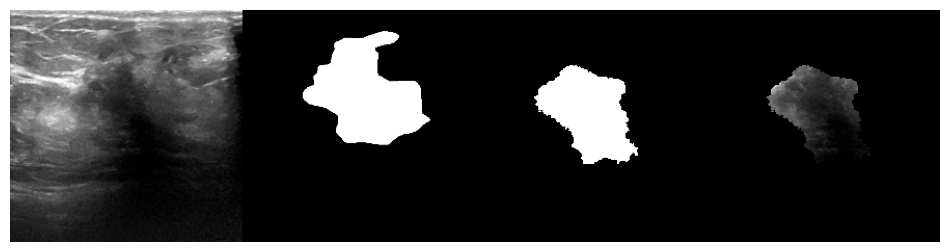

 Epoch: 55 of 100, Iter.: 16 of 16, Train Loss: 0.064128, IoU: 0.926069, Dice: 0.960631
 Epoch: 55 of 100, Iter.: 16 of 16, Valid Loss: 0.773498, IoU: 0.517867, Dice: 0.632949


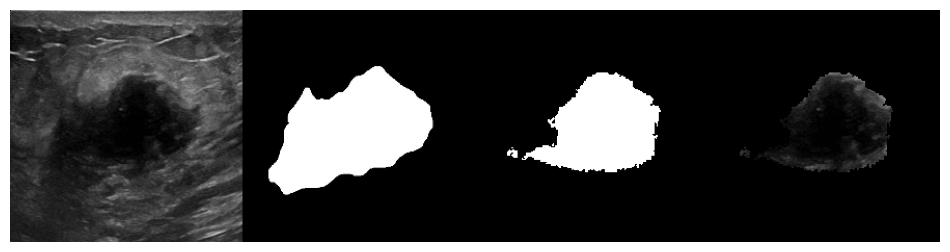

 Epoch: 56 of 100, Iter.: 16 of 16, Train Loss: 0.063027, IoU: 0.930377, Dice: 0.963587
 Epoch: 56 of 100, Iter.: 16 of 16, Valid Loss: 0.923870, IoU: 0.457995, Dice: 0.580449


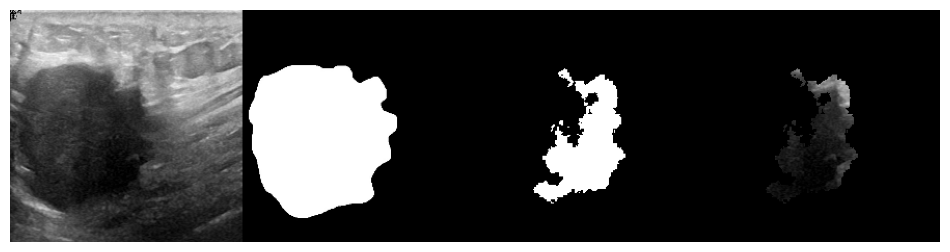

 Epoch: 57 of 100, Iter.: 16 of 16, Train Loss: 0.062431, IoU: 0.930196, Dice: 0.963531
 Epoch: 57 of 100, Iter.: 16 of 16, Valid Loss: 0.837243, IoU: 0.503046, Dice: 0.627651


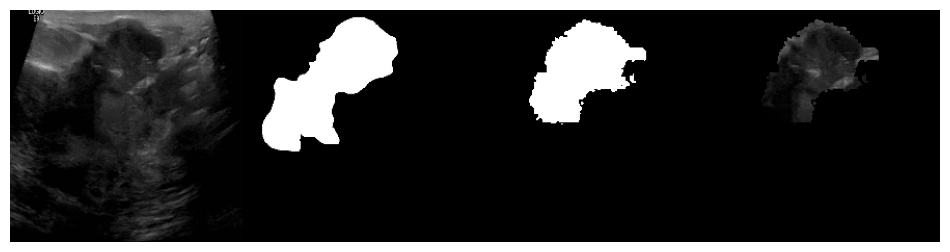

 Epoch: 58 of 100, Iter.: 16 of 16, Train Loss: 0.058045, IoU: 0.935298, Dice: 0.966306
 Epoch: 58 of 100, Iter.: 16 of 16, Valid Loss: 0.847227, IoU: 0.503044, Dice: 0.624908


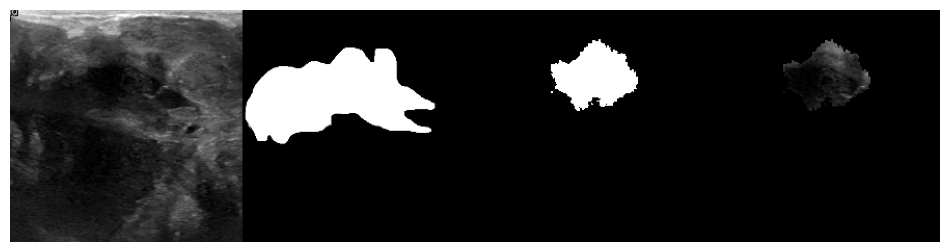

 Epoch: 59 of 100, Iter.: 16 of 16, Train Loss: 0.056275, IoU: 0.937506, Dice: 0.967519
 Epoch: 59 of 100, Iter.: 16 of 16, Valid Loss: 0.856113, IoU: 0.503598, Dice: 0.623485


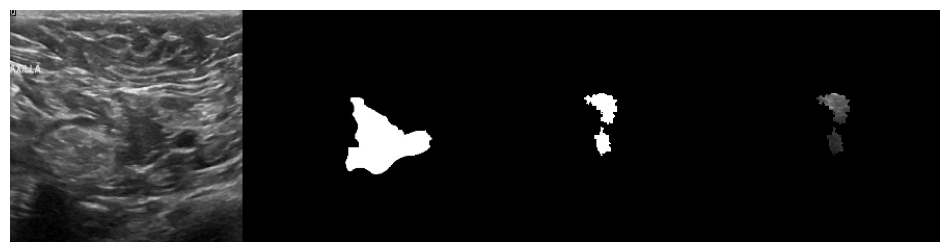

 Epoch: 60 of 100, Iter.: 16 of 16, Train Loss: 0.055216, IoU: 0.937228, Dice: 0.967330
 Epoch: 60 of 100, Iter.: 16 of 16, Valid Loss: 0.848667, IoU: 0.509542, Dice: 0.629026


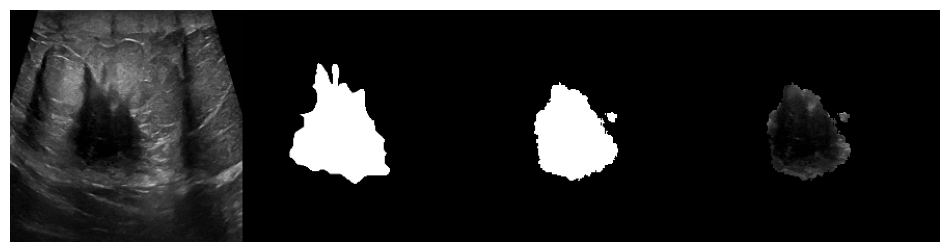

 Epoch: 61 of 100, Iter.: 16 of 16, Train Loss: 0.050950, IoU: 0.941770, Dice: 0.969804
 Epoch: 61 of 100, Iter.: 16 of 16, Valid Loss: 0.826106, IoU: 0.525872, Dice: 0.644753


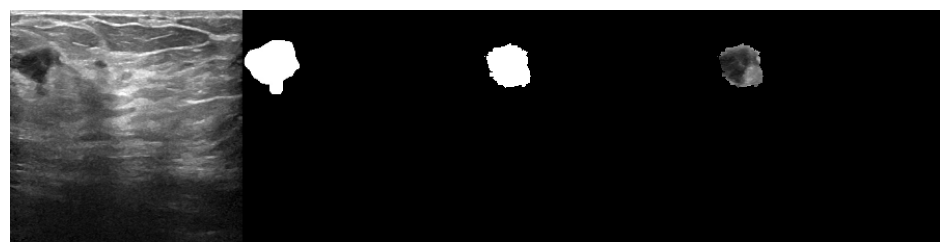

 Epoch: 62 of 100, Iter.: 16 of 16, Train Loss: 0.050283, IoU: 0.941616, Dice: 0.969722
 Epoch: 62 of 100, Iter.: 16 of 16, Valid Loss: 0.827138, IoU: 0.532257, Dice: 0.653138


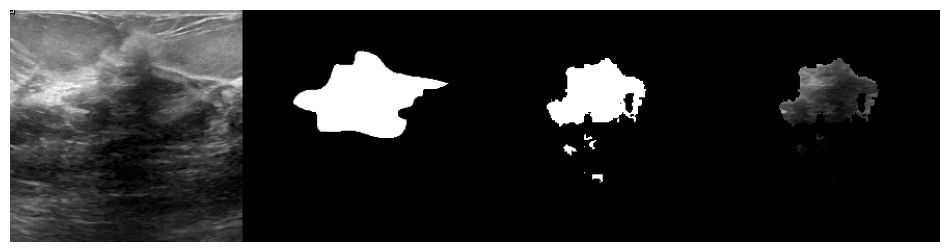

 Epoch: 63 of 100, Iter.: 16 of 16, Train Loss: 0.053550, IoU: 0.940121, Dice: 0.968930
 Epoch: 63 of 100, Iter.: 16 of 16, Valid Loss: 0.844136, IoU: 0.522161, Dice: 0.642916


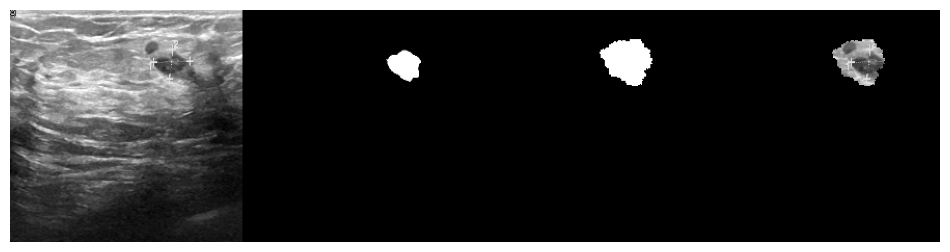

 Epoch: 64 of 100, Iter.: 16 of 16, Train Loss: 0.051962, IoU: 0.940401, Dice: 0.969075
 Epoch: 64 of 100, Iter.: 16 of 16, Valid Loss: 0.841212, IoU: 0.525822, Dice: 0.645205


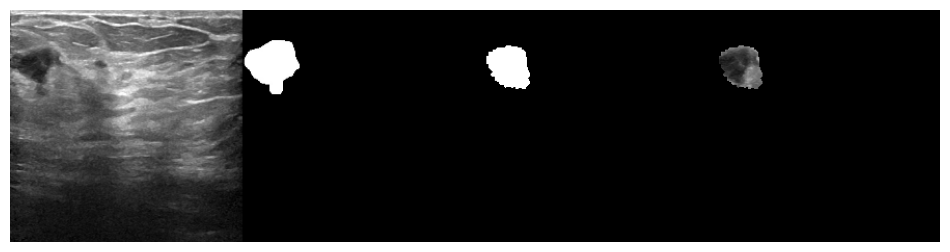

 Epoch: 65 of 100, Iter.: 16 of 16, Train Loss: 0.049039, IoU: 0.943186, Dice: 0.970537
 Epoch: 65 of 100, Iter.: 16 of 16, Valid Loss: 0.838434, IoU: 0.529652, Dice: 0.649336


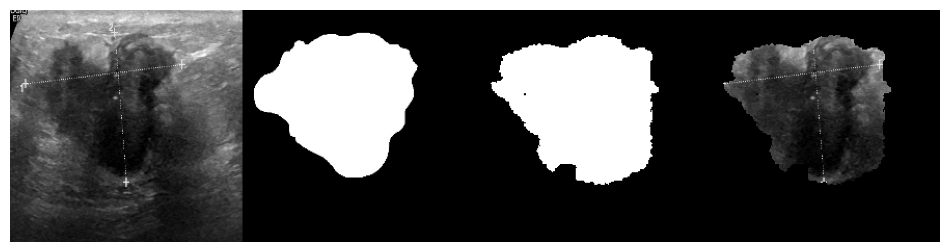

 Epoch: 66 of 100, Iter.: 16 of 16, Train Loss: 0.051033, IoU: 0.944572, Dice: 0.971331
 Epoch: 66 of 100, Iter.: 16 of 16, Valid Loss: 0.874270, IoU: 0.505835, Dice: 0.625311


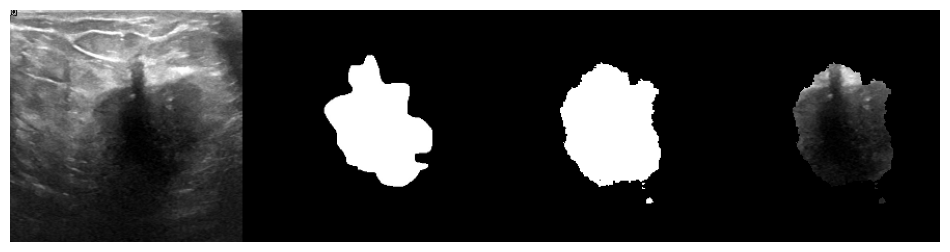

 Epoch: 67 of 100, Iter.: 16 of 16, Train Loss: 0.046720, IoU: 0.945199, Dice: 0.971644
 Epoch: 67 of 100, Iter.: 16 of 16, Valid Loss: 0.854743, IoU: 0.521893, Dice: 0.644752


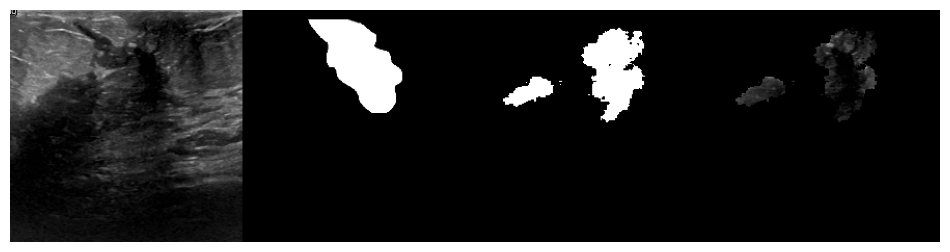


Early stopping. Target criteria has not improved for 20 epochs.

CPU times: user 4min 40s, sys: 5min 31s, total: 10min 12s
Wall time: 4min 50s


In [19]:

%%time
from ploting import plot_model_prediction

train_losses, val_losses = [], []
train_ious, val_ious = [], []
train_dices, val_dices = [], []
best_iou, best_dice, best_loss = 0, 0, np.inf
best_epoch_dice = -1
state = {}
lst_epoch_metric = []

start_time = time.time()
for epoch in range(1, epochs+1):
    running_loss, running_iou, running_dice = 0, 0, 0

    # Train
    model.train()
    for i, (imgs, masks) in enumerate(dataloader_train):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        
        optimizer.zero_grad()
        loss = criterion(prediction, masks)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        running_iou += iou_pytorch_eval(prediction, masks)
        running_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, IoU:  {:.6f},  Dice:  {:.6f}".format(epoch, epochs, i, len(dataloader_train), running_loss/(i+1), running_iou/(i+1), running_dice/(i+1)), end="")
        
    # Validate
    model.eval()
    val_loss, val_iou, val_dice = 0, 0, 0
    for i, (imgs, masks) in enumerate(dataloader_val):
        imgs, masks = imgs.to(DEVICE), masks.to(DEVICE)
        
        prediction = model(imgs)
        loss = criterion(prediction, masks)
        val_loss += loss.item()
        print("\r Epoch: {} of {}, Iter.: {} of {}, Loss: {:.6f}, Val. Loss: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_loss/len(dataloader_train), val_loss/(i+1)), end="")
        
        val_iou += iou_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, IoU: {:.6f}, Val. IoU: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_iou/len(dataloader_train), val_iou/(i+1)), end="")

        val_dice += dice_pytorch_eval(prediction, masks)
        print("\r Epoch: {} of {}, Iter.: {} of {}, Dice: {:.6f}, Val. Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), running_dice/len(dataloader_train), val_dice/(i+1)), end="")
    
    
    # compute overall epoch losses
    epoch_train_loss = running_loss/len(dataloader_train)
    train_losses.append(epoch_train_loss)
    epoch_val_loss = val_loss/len(dataloader_val)
    val_losses.append(epoch_val_loss)

    # compute overall epoch iou-s
    epoch_train_iou = (running_iou/len(dataloader_train)).item()
    train_ious.append(epoch_train_iou)
    epoch_val_iou = (val_iou/len(dataloader_val)).item()
    val_ious.append(epoch_val_iou)
    
    # compute overall epoch dice
    epoch_train_dice = (running_dice/len(dataloader_train)).item()
    train_dices.append(epoch_train_dice)
    epoch_val_dice = (val_dice/len(dataloader_val)).item()
    val_dices.append(epoch_val_dice)

    print("\r Epoch: {} of {}, Iter.: {} of {}, Train Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_train_loss, epoch_train_iou, epoch_train_dice))
    print("\r Epoch: {} of {}, Iter.: {} of {}, Valid Loss: {:.6f}, IoU: {:.6f}, Dice: {:.6f}".format(epoch, epochs, len(dataloader_train), len(dataloader_train), epoch_val_loss, epoch_val_iou, epoch_val_dice))
    if epoch == 1:
        print('\n시각화되는 이미지는 1.실제 테스트 이미지 2.실제 라벨 이미지 3.예측 라벨 4.예측한 이미지 결과의 순서입니다.')
    plot_model_prediction(model, DEVICE, valid_images, valid_labels)
        
    # plot
    metrics = {'loss':[train_losses, epoch_train_loss, val_losses, epoch_val_loss],
               'Iou':[train_ious, epoch_train_iou, val_ious,  epoch_val_iou],
               'Dice':[train_dices, epoch_train_dice, val_dices,  epoch_val_dice]}
    
    lst_epoch_metric.append([round(epoch_train_loss,4), round(epoch_train_iou,4), round(epoch_train_dice,4), 
                             round(epoch_val_loss,4), round(epoch_val_iou,4), round(epoch_val_dice,4)]) 

    # save if best results or break is has not improved for {patience} number of epochs
    best_iou = max(best_iou, epoch_val_iou)
    best_dice = max(best_dice, epoch_val_dice)
    best_loss = min(best_loss, epoch_val_loss)
    best_epoch_dice = epoch if best_dice == epoch_val_dice else best_epoch_dice

    # record losses
    state['train_losses'] = train_losses
    state['val_losses'] = val_losses
    
    if best_epoch_dice == epoch:
        # print('Saving..')
        state['net'] = model.state_dict()
        state['dice'] = best_dice
        state['epoch'] = epoch
            
        if not os.path.isdir('checkpoints'):
            os.mkdir('checkpoints')
        torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
    
    
    elif best_epoch_dice + patience < epoch:
        print(f"\nEarly stopping. Target criteria has not improved for {patience} epochs.\n")
        break

file_name = f'{model_name}_{data_name}'
# load once more and write all the losses down (othw can miss the last 10)
end_time = time.time() - start_time

state = torch.load(f'./checkpoints/ckpt_{model_name}_{data_name}.pth')
state['train_losses'] = train_losses
state['val_losses'] = val_losses
torch.save(state, f'./checkpoints/ckpt_{model_name}_{data_name}.pth')

df_epoch_metric = pd.DataFrame(lst_epoch_metric, columns = ['epoch_train_loss', 'epoch_train_iou', 'epoch_train_dice', 'epoch_val_loss', 'epoch_val_iou', 'epoch_val_dice'])
df_epoch_metric.to_csv(f'/project/segmentation/smcho1201/training_{model_name}/csv_{file_name}.csv', index_label = ['epoch'])

Validationset 기준 
Best_epoch:46, Best_IOU:0.5702, Best_DiceScore:0.6870


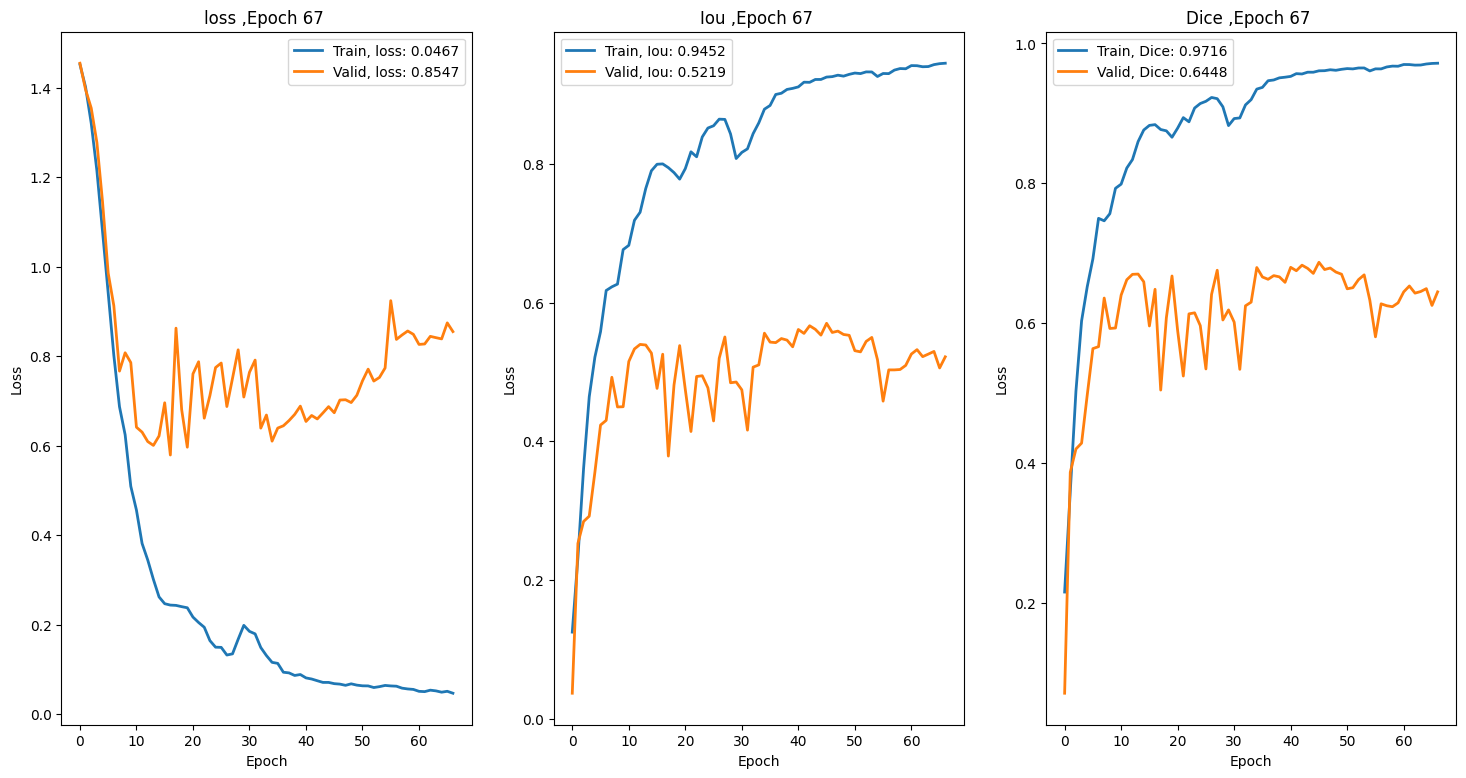

In [20]:
print(f'Validationset 기준 \nBest_epoch:{best_epoch_dice}, Best_IOU:{best_iou:.4f}, Best_DiceScore:{best_dice:.4f}')

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(18, 9))           
for i, (metric, value) in enumerate(metrics.items()):
    axs[i].plot(np.arange(len(value[0])), value[0], label=f'Train, {metric}: {value[1]:.4f}', linewidth=2)
    axs[i].plot(np.arange(len(value[2])), value[2], label=f'Valid, {metric}: {value[3]:.4f}', linewidth=2)
    axs[i].set_xlabel('Epoch')
    axs[i].set_ylabel('Loss')
    axs[i].set_title(f'{metric} ,Epoch {epoch} ')
    axs[i].legend(loc='best')
plt.show()